Say, we want to understand the relationship between the expenditures of the governments and the students' overall success in the math and reading.

### Create a new score variable from the weighted averages of all score variables in the datasets. Notice that the number of students in the 4th grade isn't the same as the number of students in the 8th grade. So, you should appropriately weigh the scores!.

### What are the correlations between this newly created score variable and the expenditure types? Which 1 of the expenditure types is more correlated than the others?

### Now, apply PCA to the 4 expenditure types. How much of the total variance is explained by the 1st component?

### What is the correlation between the overall score variable and the 1st principal component?

### If you were to choose the best variables for your model, would you prefer using the 1st principal component instead of the expenditure variables? Why?

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
#from matplotlib.mlab import PCA as mlabPCA
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sqlalchemy import create_engine
import warnings

warnings.filterwarnings('ignore')
sns.set_style("whitegrid")

In [8]:
postgres_user = 'dsbc_student'
postgres_pw = '7*.8G9QH21'
postgres_host = '142.93.121.174'
postgres_port = '5432'
postgres_db = 'useducation'

engine = create_engine('postgresql://{}:{}@{}:{}/{}'.format(
    postgres_user, postgres_pw, postgres_host, postgres_port, postgres_db))

useducation = pd.read_sql_query('select * from useducation',con=engine)

engine.dispose()

In [9]:
useducation_c = useducation.copy()

In [10]:
#change all the wrong state to real one
useducation_c['STATE'].replace(to_replace =['COMMONWEALTH_OF_MARIANAS', 'MARIANAS',  'NORTHERN_MARIANAS' ,  'NORTHERN_MARIANA_ISLANDS',  'MP'], value ='Northern Mariana Island', inplace=True) 
useducation_c['STATE'].replace(to_replace =['VIRGIN_ISLANDS',  'U.S._VIRGIN_ISLANDS' , 'VI'], value ='U.S. Virgin Island', inplace = True)
useducation_c['STATE'].replace(to_replace =['PR'], value ='PUERTO_RICO', inplace = True)
useducation_c['STATE'].replace(to_replace =['GU'], value ='GUAM', inplace = True)
useducation_c['STATE'].replace(to_replace =['AS'], value ='AMERICAN_SAMOA', inplace=True)
useducation_c['STATE'].replace(to_replace =['BUREAU_OF_INDIAN_AFFAIRS',  'BI',  'BIE',  'BUREAU_OF_INDIAN_EDUCATIO',  'BUREAU_OF_INDIAN_EDUCATION'], value ='DISTRICT_OF_COLUMBIA', inplace=True)
useducation_c['STATE'].replace(to_replace =['DOD_-_OVERSEAS',  'DOD_-_DOMESTIC',  'DOD','DOD_OVERSEAS', 'DOD_DOMESTIC','DD','DEPARTMENT_OF_DEFENSE','DEPARTMENT_OF_DEFENSE_EDUCATION_ACTIVITY', 'DOD_(OVERSEAS_AND_DOMESTIC_COMBINED)' ,  'DOD_-_FOREIGN'], value ='VIRGINIA', inplace=True)


In [11]:
useducation_c.replace(to_replace =['n/a', 'na', 'nan','NaN','NA', '--','...', 'inf'], value ='NaN', inplace = True)
useducation_c.columns = [x.capitalize() for x in useducation_c.columns]
useducation_c.State = [x.capitalize() for x in useducation_c.State]

In [12]:
use_c=useducation_c.groupby("State")

In [13]:
used_c = use_c.apply(lambda x: x.fillna(x.interpolate(method = 'linear', axis = 0, limit_direction = 'both')))
used_c.head()

,Primary_key,State,Year,Enroll,Total_revenue,Federal_revenue,State_revenue,Local_revenue,Total_expenditure,Instruction_expenditure,...,Grades_4_g,Grades_8_g,Grades_12_g,Grades_1_8_g,Grades_9_12_g,Grades_all_g,Avg_math_4_score,Avg_math_8_score,Avg_reading_4_score,Avg_reading_8_score
0,1992_ALABAMA,Alabama,1992,727716.0,2678885.0,304177.0,1659028.0,715680.0,2653798.0,1481703.0,...,57948.0,58025.0,41167.0,471564.0,196386.0,676174.0,208.327876,252.187522,207.963517,260.276441
1,1992_ALASKA,Alaska,1992,121156.0,1049591.0,106780.0,720711.0,222100.0,972488.0,498362.0,...,9748.0,8789.0,6714.0,79117.0,30847.0,112335.0,223.833455,277.643071,211.547154,258.859712
2,1992_ARIZONA,Arizona,1992,676297.0,3258079.0,297888.0,1369815.0,1590376.0,3401580.0,1435908.0,...,55433.0,49081.0,37410.0,437127.0,175210.0,614881.0,215.253932,265.366278,206.212716,262.169895
3,1992_ARKANSAS,Arkansas,1992,311432.0,1711959.0,178571.0,958785.0,574603.0,1743022.0,964323.0,...,34632.0,36011.0,27651.0,281338.0,123113.0,405259.0,210.206028,256.312090,208.634458,264.619665
4,1992_CALIFORNIA,California,1992,5129788.0,26260025.0,2072470.0,16546514.0,7641041.0,27138832.0,14358922.0,...,418418.0,363296.0,270675.0,3286034.0,1372011.0,4717112.0,208.398961,260.892247,196.764414,269.197451


In [14]:
used_c.dropna(inplace=True)

### Create a new score variable from the weighted averages of all score variables in the datasets. Notice that the number of students in the 4th grade isn't the same as the number of students in the 8th grade. So, you should appropriately weigh the scores!.

In [17]:
used_c["overall_score"] = (used_c["Grades_4_g"]*((used_c["Avg_math_4_score"] + 
                                                              used_c["Avg_reading_4_score"])*0.5) + 
                                 used_c["Grades_8_g"]* ((used_c["Avg_math_8_score"] + 
                                                               used_c["Avg_reading_8_score"])*0.5))/(used_c["Grades_4_g"] + used_c["Grades_8_g"])



In [18]:
used_c.head()

,Primary_key,State,Year,Enroll,Total_revenue,Federal_revenue,State_revenue,Local_revenue,Total_expenditure,Instruction_expenditure,...,Grades_8_g,Grades_12_g,Grades_1_8_g,Grades_9_12_g,Grades_all_g,Avg_math_4_score,Avg_math_8_score,Avg_reading_4_score,Avg_reading_8_score,overall_score
0,1992_ALABAMA,Alabama,1992,727716.0,2678885.0,304177.0,1659028.0,715680.0,2653798.0,1481703.0,...,58025.0,41167.0,471564.0,196386.0,676174.0,208.327876,252.187522,207.963517,260.276441,232.204803
1,1992_ALASKA,Alaska,1992,121156.0,1049591.0,106780.0,720711.0,222100.0,972488.0,498362.0,...,8789.0,6714.0,79117.0,30847.0,112335.0,223.833455,277.643071,211.547154,258.859712,241.662975
2,1992_ARIZONA,Arizona,1992,676297.0,3258079.0,297888.0,1369815.0,1590376.0,3401580.0,1435908.0,...,49081.0,37410.0,437127.0,175210.0,614881.0,215.253932,265.366278,206.212716,262.169895,235.639070
3,1992_ARKANSAS,Arkansas,1992,311432.0,1711959.0,178571.0,958785.0,574603.0,1743022.0,964323.0,...,36011.0,27651.0,281338.0,123113.0,405259.0,210.206028,256.312090,208.634458,264.619665,235.441283
4,1992_CALIFORNIA,California,1992,5129788.0,26260025.0,2072470.0,16546514.0,7641041.0,27138832.0,14358922.0,...,363296.0,270675.0,3286034.0,1372011.0,4717112.0,208.398961,260.892247,196.764414,269.197451,231.610996


### What are the correlations between this newly created score variable and the expenditure types? Which 1 of the expenditure types is more correlated than the others?

In [22]:
used_c.columns.unique()

Index(['Primary_key', 'State', 'Year', 'Enroll', 'Total_revenue',
       'Federal_revenue', 'State_revenue', 'Local_revenue',
       'Total_expenditure', 'Instruction_expenditure',
       'Support_services_expenditure', 'Other_expenditure',
       'Capital_outlay_expenditure', 'Grades_pk_g', 'Grades_kg_g',
       'Grades_4_g', 'Grades_8_g', 'Grades_12_g', 'Grades_1_8_g',
       'Grades_9_12_g', 'Grades_all_g', 'Avg_math_4_score', 'Avg_math_8_score',
       'Avg_reading_4_score', 'Avg_reading_8_score', 'overall_score'],
      dtype='object')

In [23]:
used_c[['overall_score','Total_expenditure', 'Instruction_expenditure', 
        'Support_services_expenditure', 'Other_expenditure','Capital_outlay_expenditure']].corr()



,overall_score,Total_expenditure,Instruction_expenditure,Support_services_expenditure,Other_expenditure,Capital_outlay_expenditure
overall_score,1.000000,0.137111,0.144378,0.146700,0.071017,0.062421
Total_expenditure,0.137111,1.000000,0.991332,0.993004,0.945643,0.929108
Instruction_expenditure,0.144378,0.991332,1.000000,0.976480,0.908685,0.892206
Support_services_expenditure,0.146700,0.993004,0.976480,1.000000,0.952701,0.913035
Other_expenditure,0.071017,0.945643,0.908685,0.952701,1.000000,0.919822
Capital_outlay_expenditure,0.062421,0.929108,0.892206,0.913035,0.919822,1.000000


none of looks highly corelated

### Now, apply PCA to the 4 expenditure types. How much of the total variance is explained by the 1st component?


The percentage of total variance in the dataset explained by each component from Sklearn PCA.
 [0.94548244]


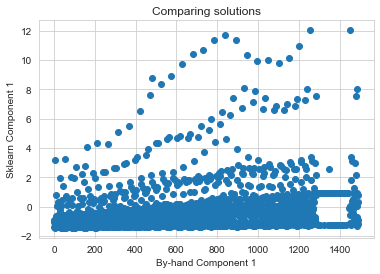

In [27]:
X=used_c[['Instruction_expenditure', 'Support_services_expenditure', 'Other_expenditure','Capital_outlay_expenditure']]

# Normalize the data so that all variables have a mean of 0 and standard deviation
# of 1.
X = StandardScaler().fit_transform(X)
sklearn_pca = PCA(n_components=1)
used_c["pca_1"] = sklearn_pca.fit_transform(X)

print(
    'The percentage of total variance in the dataset explained by each',
    'component from Sklearn PCA.\n',
    sklearn_pca.explained_variance_ratio_
)

# Compare the sklearn solution to ours – a perfect match.
plt.plot(used_c["pca_1"],'o')
plt.title('Comparing solutions')
plt.ylabel('Sklearn Component 1')
plt.xlabel('By-hand Component 1')
plt.show()

### What is the correlation between the overall score variable and the 1st principal component?

In [29]:
used_c[['overall_score', 'pca_1', 'Instruction_expenditure', 'Support_services_expenditure', 
        'Other_expenditure','Capital_outlay_expenditure']].corr()
       
       
       

,overall_score,pca_1,Instruction_expenditure,Support_services_expenditure,Other_expenditure,Capital_outlay_expenditure
overall_score,1.000000,0.109474,0.144378,0.146700,0.071017,0.062421
pca_1,0.109474,1.000000,0.971455,0.988147,0.972252,0.957339
Instruction_expenditure,0.144378,0.971455,1.000000,0.976480,0.908685,0.892206
Support_services_expenditure,0.146700,0.988147,0.976480,1.000000,0.952701,0.913035
Other_expenditure,0.071017,0.972252,0.908685,0.952701,1.000000,0.919822
Capital_outlay_expenditure,0.062421,0.957339,0.892206,0.913035,0.919822,1.000000


dont know????

### If you were to choose the best variables for your model, would you prefer using the 1st principal component instead of the expenditure variables? Why?

In [ ]:
No, 